In [1]:
import os
import pickle
import igraph
import geoplot
import seaborn as sns
from collections import Counter
import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
import mapclassify as mc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import contextily as ctx
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import matplotlib.colors as colors
import matplotlib.ticker as mtick
from collections import defaultdict
import cartopy
import sys
from mpl_toolkits.basemap import Basemap

from statsmodels.nonparametric.kernel_density import *

import GeoDataProcessing.dispatchAnalysis as DA

In [4]:
def loadVehicleRelocations(vehicleRecord, nodes_shp):
    outputDict = {'dashed': [], 'line': [], 'emergency': [], 'marker':[], 'specialMarker':[]}
    for i in range(2, len(vehicleRecord) - 1):
        if vehicleRecord[i][2] is None:
            outputDict['marker'].append((vehicleRecord[i][0], vehicleRecord[i][1]))
        else:
            if vehicleRecord[i+1][1] == vehicleRecord[i][2]:
                if vehicleRecord[i][3] == 'None':
                    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                    j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                    outputDict['line'].append((vehicleRecord[i][0], i_coords, j_coords))
                else:
                    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                    j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                    outputDict['emergency'].append((vehicleRecord[i][0], i_coords, j_coords))
            else:
                i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][2]][['lon', 'lat']].values[0]
                outputDict['dashed'].append((vehicleRecord[i][0], i_coords, j_coords))

                i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i][1]][['lon', 'lat']].values[0]
                j_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[i+1][1]][['lon', 'lat']].values[0]
                outputDict['line'].append((vehicleRecord[i][0], i_coords, j_coords))

    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[1][2]][['lon', 'lat']].values[0]
    outputDict['specialMarker'].append((vehicleRecord[1][0], i_coords))
    
    i_coords = nodes_shp[nodes_shp['osmid'] == vehicleRecord[-1][1]][['lon', 'lat']].values[0]
    outputDict['specialMarker'].append((vehicleRecord[-1][0], i_coords))
    return outputDict

def buildRelocationMap(elements):
    fig, axs = plt.subplots(1,1, figsize=(15,15))
    base = Basemap(llcrnrlon=-74.2555913631521349,llcrnrlat=40.4961153951892072,urcrnrlon=-73.7000090632127183,urcrnrlat=40.9155327760000773, epsg=4326, ax=axs)
    
    DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
    base.readshapefile(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries', 'borough')

    for e in elements['dashed']:
        #print(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1])
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='black', linestyle='--')
    for e in elements['line']:
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='black', linestyle='-')
    for e in elements['emergency']:
        base.plot(np.array(e[1:])[:, 0], np.array(e[1:])[:, 1], marker='D', color='blue', linestyle='-')
    for e in elements['specialMarker']:
        base.plot(e[1][0], e[1][1], marker='D', color='lightgreen', linestyle='-')


In [167]:
def visualize(statistic, show_mean = True, figsize=None):
        if figsize is not None:
            fig, ax = plt.subplots(1,1, figsize=figsize)

        x = []
        y = []
        for i in range(len(statistic.data) - 1):
            if statistic.data[i][0] != statistic.data[i+1][0]:
                x.append(statistic.data[i][0])
                x.append(statistic.data[i+1][0])
                y.append(statistic.data[i][1])
                y.append(statistic.data[i][1])
        plt.plot(x, y, '-')
        
        if show_mean:
            plt.plot([0, statistic.data[-1][0]], [statistic.average()]*2, 'r-')
        
        plt.title('StateStatistic ' + statistic.name + ' over time')
        plt.show()

In [6]:
DATA_DIR = ''
nodes_with_borough = gpd.read_file(DATA_DIR + 'NYC Graph//NYC_nodes_w_borough//NYC_nodes_w_borough.shp')
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
nyc_boundaries = gpd.read_file(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries.shp')

## Model config name

In [2]:
name = 'D:/FTP results/Final1/friday_{}_0_0.7_0.05_Base_355ALS802BLS_86400_250_8_864000_60_1_1e-10_2160_1200_800_3600.pickle'

### Expected survivors

In [539]:
def SurvivalFunction(response_times):
        return (1 + np.exp(0.679 + .262 * response_times)) ** -1
#with open(name.format('SBRDAStatic'), 'rb') as f:
#    statistics = pickle.load(f)
#print('SBRDAStatic', [sum(SurvivalFunction((e[4] - e[3])/60) if e[2] == 1 and statistics[1][e[-1]]['Statistics']['Borough'].data == b else 0 for e in statistics[2]) for b in range(1,6)])
with open(name.format('SBRDANew'), 'rb') as f:
    statistics = pickle.load(f)
#A = [SurvivalFunction((e[4] - e[3])/60) if e[2] == 1 and statistics[1][e[-1]]['Statistics']['Borough'].data == b else 0 for e in statistics[2] for b in range(1,6)]
A = [SurvivalFunction((e[4] - e[3])/60) for e in statistics[2] for b in range(1,6) if e[2] == 1 and statistics[1][e[-1]]['Statistics']['Borough'].data == b]
#print('SBRDANew   ', A)
product = 1
for e in A[:100]:
    product *= e
print(product)

#with open(name.format('SBRDA'), 'rb') as f:
#    statistics = pickle.load(f)
#print('SBRDA      ', [sum(SurvivalFunction((e[4] - e[3])/60) if e[2] == 1 and statistics[1][e[-1]]['Statistics']['Borough'].data == b else 0 for e in statistics[2]) for b in range(1,6)])
#with open(name.format('ROA'), 'rb') as f:
#    statistics = pickle.load(f)
#
#A = [SurvivalFunction((e[4] - e[3])/60) if e[2] == 1 and statistics[1][e[-1]]['Statistics']['Borough'].data == b else 0 for e in statistics#[2] for b in range(1,6)]
#print('ROA        ', A)
#product = 1
#for e in A:
#    product *= e
#print(prod)

2.237303009899172e-98


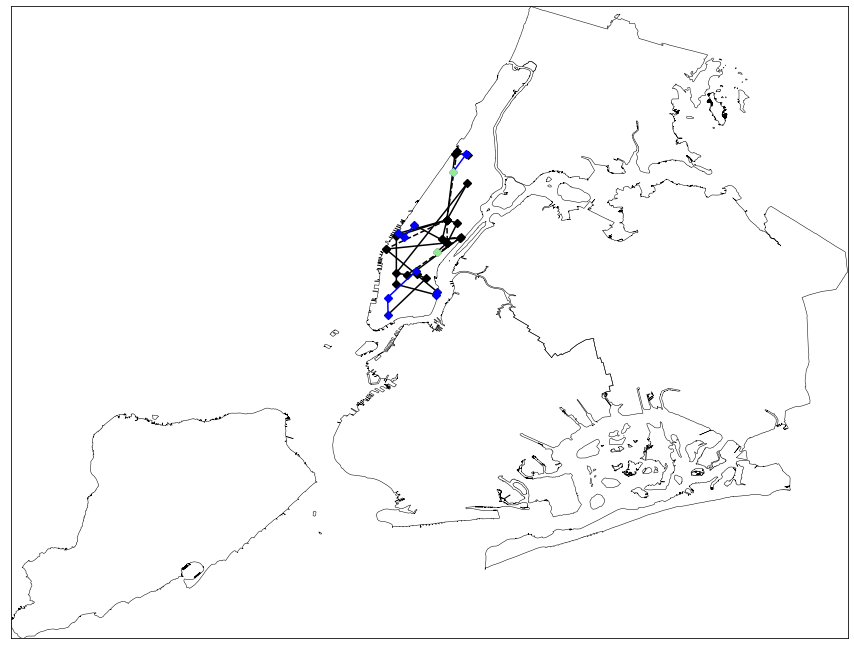

In [9]:
fixed_model = 'SBRDANew'
ambulance = 'Ambulance 0'
with open(name.format(fixed_model), 'rb') as f:
    statistics = pickle.load(f)
buildRelocationMap(loadVehicleRelocations(statistics[1][ambulance]['Record'], nodes_with_borough))

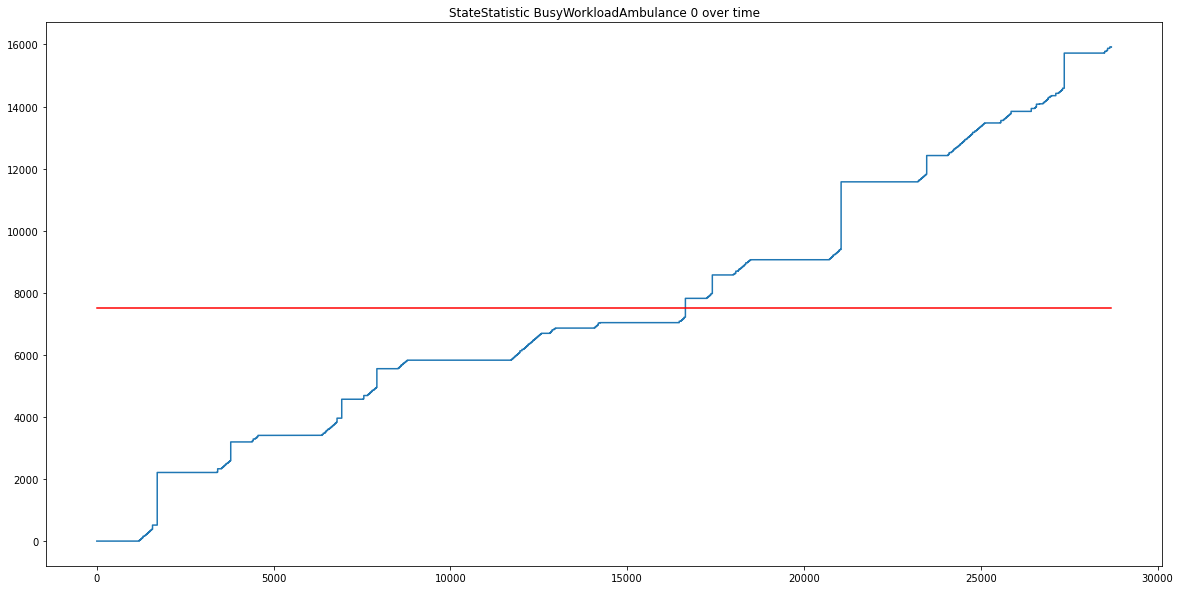

[(0, '42979730', '42979730', 'None', None),
 (0, '1504153626', '1504153626', 'None', None),
 (1193.0, '1504153626', '61257626', 'Emergency 151173', None),
 (3403.60140016512,
  '61257626',
  '1506445711',
  'Emergency 151173',
  '1506445711'),
 (4387.5432387914825, '1506445711', '42426374', 'None', None),
 (6373.0, '42426374', '61257626', 'Emergency 151225', None),
 (7536.589383853304,
  '61257626',
  '1506445711',
  'Emergency 151225',
  '1506445711'),
 (8520.531222479665, '1506445711', '42429541', 'None', None),
 (11720.0, '42429541', '42439553', 'None', None),
 (12813.0, '42439553', '42430063', 'None', None),
 (14074.0, '42430063', '42443037', 'None', None),
 (16471.0, '42443037', '42434169', 'Emergency 151314', None),
 (17253.469401167098, '42434169', '42438961', 'Emergency 151314', '42438961'),
 (18007.3929565294, '42438961', '1504153626', 'None', None),
 (20713.0, '1504153626', '42429557', 'Emergency 151341', None),
 (23222.2451702643,
  '42429557',
  '1506445711',
  'Emergency 1

In [438]:
with open(name.format(fixed_model), 'rb') as f:
    statistics = pickle.load(f)
visualize(statistics[1][ambulance]['Statistics']['BusyWorkload'], figsize=(20,10))
statistics[1][ambulance]['Record']

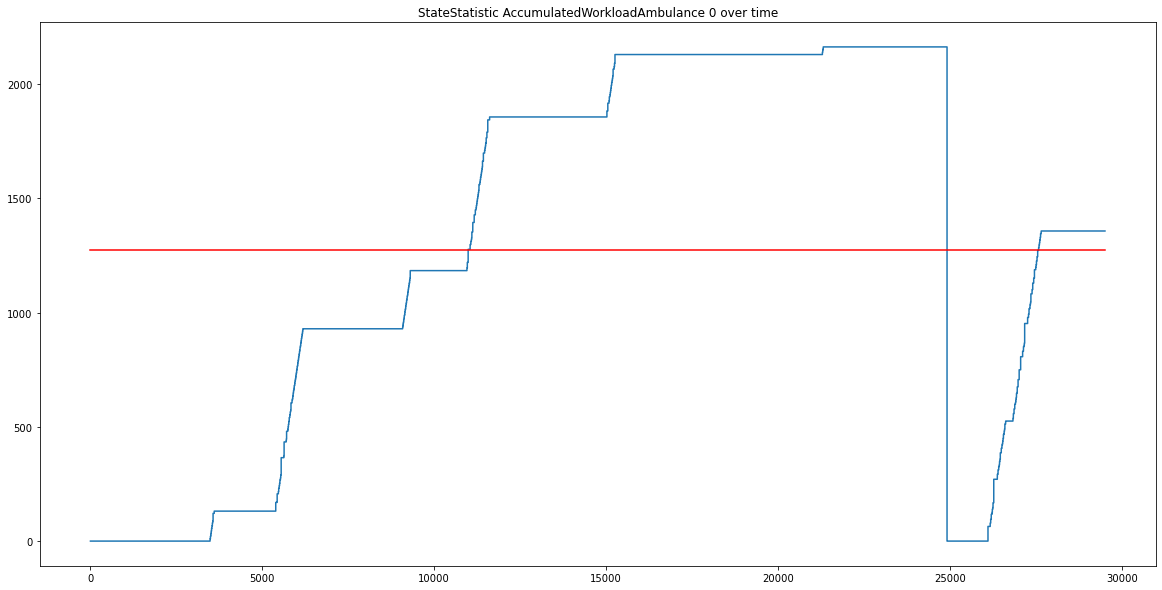

[(0, '1396345935', '1396345935', 'None', None),
 (0, '1504153626', '1504153626', 'None', None),
 (254.0, '1504153626', '61257626', 'Emergency 136678', None),
 (2494.9024923755087,
  '61257626',
  '1506445711',
  'Emergency 136678',
  '1506445711'),
 (3478.8443310018715, '1506445711', '42429541', 'None', None),
 (3606.0, '1506599378', '42427216', 'Emergency 136732', None),
 (4437.379927688772, '42427216', '42455234', 'Emergency 136732', '42455234'),
 (5389.305601462101, '42455234', '42426374', 'None', None),
 (8180.0, '42426374', '42453258', 'Emergency 136756', None),
 (9078.752487066298, '42453258', '42439553', 'None', None),
 (9318.0, '42426374', '42447285', 'Emergency 136769', None),
 (10149.663716655905,
  '42447285',
  '1506445711',
  'Emergency 136769',
  '1506445711'),
 (10949.01833767049, '1506445711', '42443037', 'None', None),
 (13761.0, '42443037', '42434169', 'Emergency 136819', None),
 (14266.34345169302, '42434169', '42438961', 'Emergency 136819', '42438961'),
 (15020.2670

In [355]:
visualize(statistics[1][ambulance]['Statistics']['AccumulatedWorkload'], figsize=(20,10))
statistics[1][ambulance]['Record']
# statistics[1][ambulance]['Statistics']['State'].data

### Utiization per borough

In [542]:
model = [ 'SBRDANew', 'ROA']
utilization = []
for m in model:
    with open(name.format(m), 'rb') as f:
        statistics = pickle.load(f)
    for v in statistics[1].keys():
        ambulance_time = statistics[1][v]['Statistics']['TimeInSystem'].data        
        borough = statistics[1][v]['Statistics']['Borough'].data
        Type = statistics[1][v]['Statistics']['Type'].data
        Shift = statistics[1][v]['Statistics']['Shift'].data
        MetersDriven = statistics[1][v]['Statistics']['MetersDriven'].data[-1][1]

        vehicle_state_1_time = 0
        vehicle_state_2_time = 0
        for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
            if d[1] == 1:
                vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
            elif d[1] == 2:
                vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]

        relocations = 0
        for i, r in enumerate(statistics[1][v]['Record'][1:]):
            if r[1] is not None and r[2] is not None and r[3] == 'None' and statistics[1][v]['Record'][i][3] == 'None':
                relocations += 1
        
        #print(v, ambulance_time, vehicle_state_1_time, vehicle_state_2_time)
        server_utilization = [m, Shift, borough, Type, v, relocations, statistics[1][v]['Statistics']['BusyWorkload'].data[-1][1]/ambulance_time, (ambulance_time - vehicle_state_1_time - vehicle_state_2_time)/ambulance_time, vehicle_state_1_time/ambulance_time, vehicle_state_2_time/ambulance_time, MetersDriven]
        utilization.append(server_utilization)
utilization_df = pd.DataFrame(utilization, columns = ['Model', 'Shift', 'Borough', 'Type', 'id', 'Relocations', 'Busy', 'Idle', 'Reloc', 'Att', 'MetersDriven']).sort_values(['Model','Idle'])        

#### Plot

Text(0.5, 0.98, 'Busy fraction')

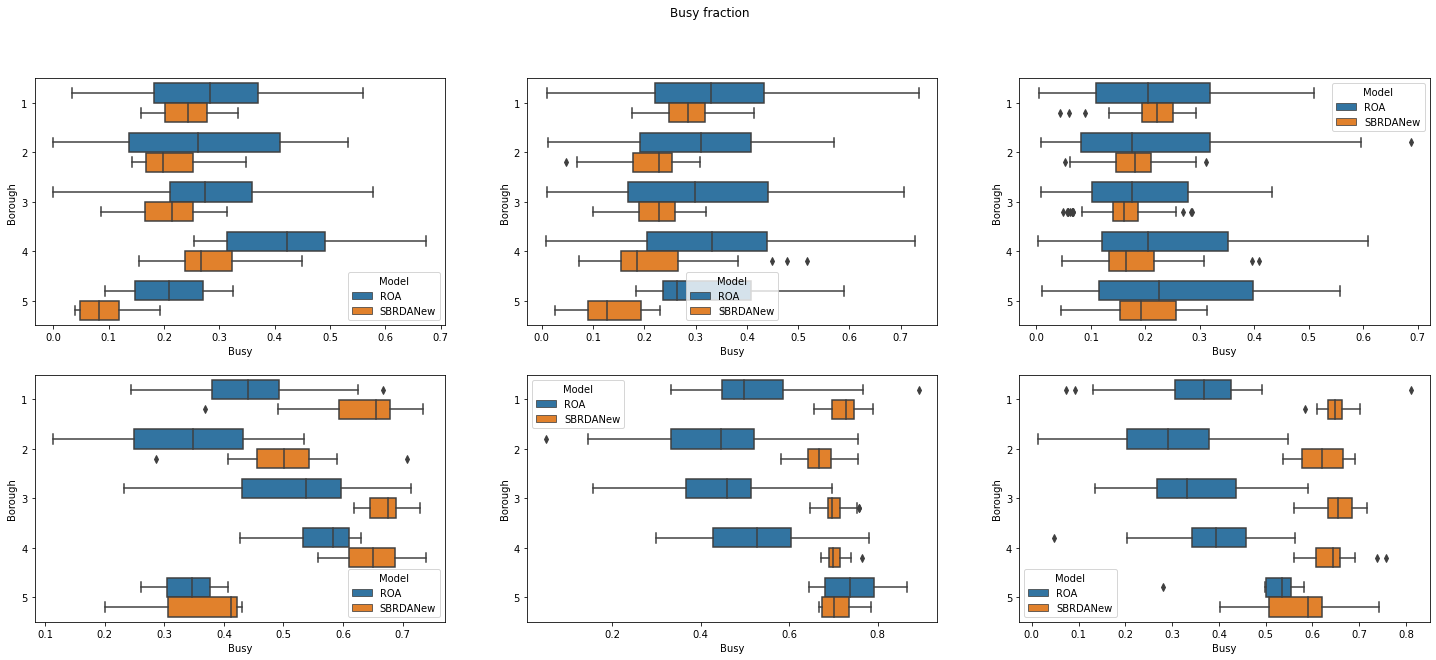

In [543]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[0,2])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='Busy', orient='h', ax = axs[1,2])

fig.suptitle('Busy fraction')
#plt.legend(handles=[a, b], loc="upper left")

Text(0.5, 0.98, 'Meters Driven')

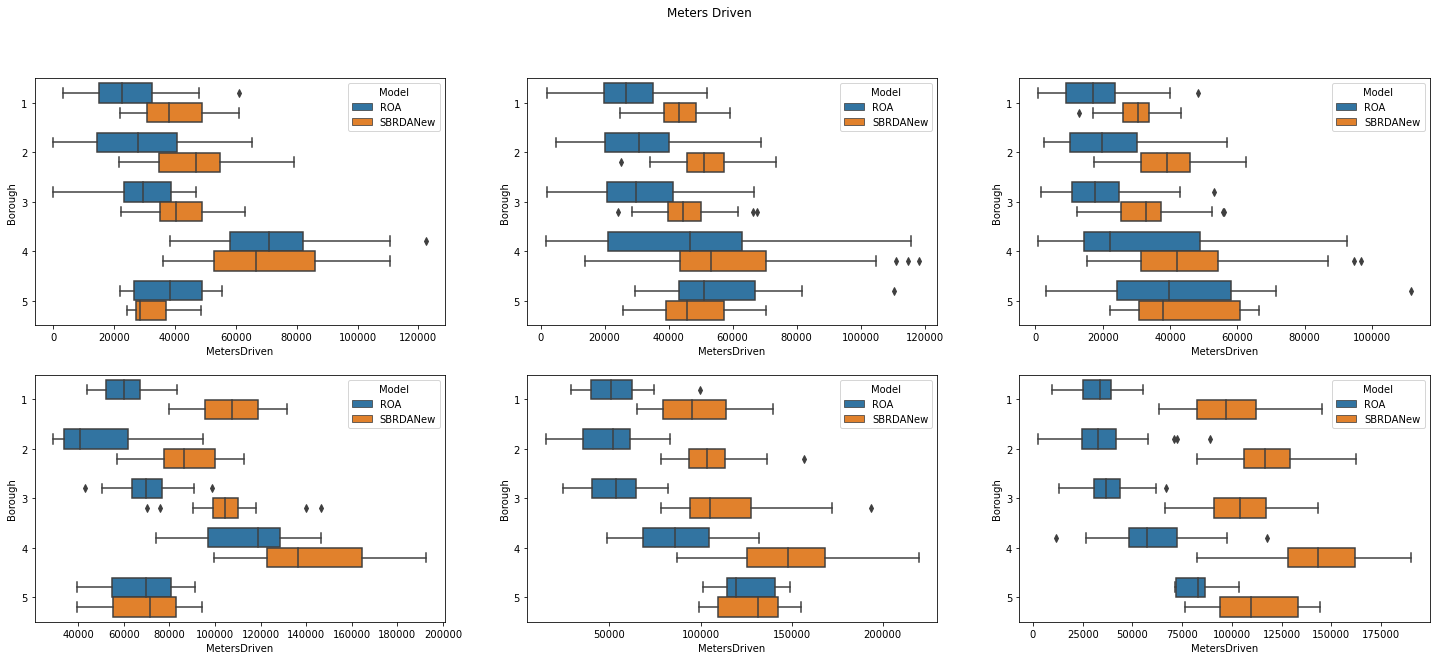

In [531]:
fig, axs = plt.subplots(2,3, figsize=(25,10))
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 1) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[0,2])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 1)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,0])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 2)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,1])
sns.boxplot(data=utilization_df[(utilization_df['Type'] == 0) & (utilization_df['Shift'] == 3)], y='Borough', hue='Model', x='MetersDriven', orient='h', ax = axs[1,2])

fig.suptitle('Meters Driven')

In [544]:
file_name = 'D:/FTP results/Final1/friday_{}_0_0.7_0.05_Base_355ALS802BLS_86400_250_8_864000_60_1_1e-10_2160_1200_800_3600.pickle'
data = []
for model, replica, vehicles in itertools.product(['SBRDANew',  'ROA'], [0], [[355, 802]]):
    with open(file_name.format(model, replica, vehicles[0], vehicles[1]), 'rb') as f:
        statistics = pickle.load(f)

    A = [1 if d[1] < 6 * 60 else 0 for d in statistics[0]['HSresponseTime'].data]
    B = [1 if d[1] < 5 * 60 else 0 for d in statistics[0]['HSresponseTime'].data]
    C = [1 if d[1] < 4 * 60 else 0 for d in statistics[0]['HSresponseTime'].data]
    D = [1 if d[1] < 3 * 60 else 0 for d in statistics[0]['HSresponseTime'].data]
    
    data.append([model, vehicles[0] / 355, statistics[0]['HSresponseTime'].average(), statistics[0]['LSresponseTime'].average(), statistics[0]['PercentageALSlt10min'].data[-1][1], statistics[0]['PercentageALSlt8min'].data[-1][1], statistics[0]['PercentageALSlt7min'].data[-1][1], np.std([d[1] for d in statistics[0]['HSresponseTime'].data]), sum(A)/len(A),sum(B)/len(B), sum(C)/len(C), sum(D)/len(D)])
data_df = pd.DataFrame(data, columns=['Model', 'Vehicle Availability', 'HS response time', 'LS response time', '% ALS lt 10min', '% ALS lt 8min', '% ALS lt 7min', 'HS resp std', '% ALS lt 6min', '% ALS lt 5min', '% ALS lt 4min', '% ALS lt 3min'])

In [545]:
data_df.groupby(['Model', 'Vehicle Availability']).mean()

,,HS response time,LS response time,% ALS lt 10min,% ALS lt 8min,% ALS lt 7min,HS resp std,% ALS lt 6min,% ALS lt 5min,% ALS lt 4min,% ALS lt 3min
Model,Vehicle Availability,,,,,,,,,,
ROA,1.0,289.862227,205.613763,0.957756,0.905817,0.829640,249.776922,0.740997,0.627424,0.475762,0.310942
SBRDANew,1.0,255.557307,404.308054,0.942640,0.893573,0.855563,232.777110,0.796130,0.704907,0.596406,0.457498


In [535]:
print()

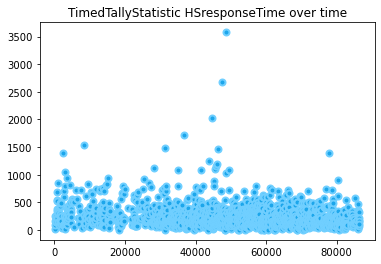

893

In [541]:
with open(name.format('SBRDANew'), 'rb') as f:
#with open('test5.pickle', 'rb') as f:
    statistics = pickle.load(f)
statistics[0]['HSresponseTime'].visualize()
len(statistics[0]['UberCalls'].data)
#L = [(s[4] - s[3], s) for s in statistics[2] if s[4] - s[3] > 5000]
#L.sort(key=lambda x: x[1][3])
#L